# Extracting Metrics from text using TextDescriptives


<a target="_blank" href="https://colab.research.google.com/github/centre-for-humanities-computing/DaCy/blob/main/textdescriptives_integration.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

DaCy allows you to use other packages in the spaCy universe as you normally would - just powered by the DaCy models.

The following tutorial shows you how to use DaCy and [TextDescriptives](https://github.com/HLasse/TextDescriptives/) to extract a variety of metrics from text. For more information on the metrics that can be extracted, see the [TextDescriptives documentation](https://hlasse.github.io/TextDescriptives/index.html).


## Data
In this tutorial we'll use TextDescriptives and DaCy, to get a quick overview of the [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).
The dataset contains 5572 SMS messages categorized as ham or spam. 

```{note}
The estute among you will have noticed that this dataset is not Danish. This tutorial simply want to show how to use DaCy and TextDescriptives together and 
hopefully inspire you to use the tools on your own (Danish) data.
```

To start, let's load a dataset and get a bit familiar with it.

In [1]:
from textdescriptives.utils import load_sms_data

df = load_sms_data()
df.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [2]:
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

## Adding TextDescriptives components to DaCy

Adding TextDescriptives components to a DaCy pipeline, follows exactly the same procedure as for any spaCy model. Let's add the `readability` and `dependency_distance` components. `Readability` is a component that calculates readability metrics, and `dependency_distance` is a component that calculates the average dependency distance between words in a sentence. This can be seen a measure of sentence complexity.

Because we are using a DaCy model, the `dependency_distance` component will use the dependency parser from DaCy for its calculations.

In [3]:
import dacy
nlp = dacy.load("small") # load the latest version of the small model

nlp.add_pipe("textdescriptives/readability")
nlp.add_pipe("textdescriptives/dependency_distance")

/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'da_dacy_medium_trf' (0.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'da_dacy_small_trf' (0.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy_tran

From now on, whenever we pass a document through the pipeline (`nlp`), TextDescriptives will add readability and dependency distance metrics to the document.

Let's load the data and pass it through the pipeline.

In [4]:
# to speed things up (especially on cpu) let's subsample the data
df = df.sample(500)

doc = nlp.pipe(df["message"])

In [5]:
import textdescriptives as td
# extract the metrics as a dataframe
metrics = td.extract_df(doc, include_text=False)

/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy/pipeline/attributeruler.py:150: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [6]:
# join the metrics to the original dataframe
df = df.join(metrics, how="left")
df.head()

label                                            message  \
4420   ham  Still at west coast... Haiz... ÌÏ'll take fore...   
1204  spam  WIN a year supply of CDs 4 a store of ur choic...   
5552   ham  Have a safe trip to Nigeria. Wish you happines...   
4250   ham  Omg Joanna is freaking me out. She's looked th...   
1699   ham                                              Ok...   

      dependency_distance_mean  dependency_distance_std  \
4420                       NaN                      NaN   
1204                       NaN                      NaN   
5552                       NaN                      NaN   
4250                       NaN                      NaN   
1699                       NaN                      NaN   

      prop_adjacent_dependency_relation_mean  \
4420                                     NaN   
1204                                     NaN   
5552                                     NaN   
4250                                     NaN   
1699                                     NaN   

      prop_adjacent_dependency_relation_std  token_length_mean  \
4420                                    NaN                NaN   
1204                                    NaN                NaN   
5552                                    NaN                NaN   
4250                                    NaN                NaN   
1699                                    NaN                NaN   

      token_length_median  token_length_std  sentence_length_mean  ...  \
4420                  NaN               NaN                   NaN  ...   
1204                  NaN               NaN                   NaN  ...   
5552                  NaN               NaN                   NaN  ...   
4250                  NaN               NaN                   NaN  ...   
1699                  NaN               NaN                   NaN  ...   

      n_characters  n_sentences  flesch_reading_ease  flesch_kincaid_grade  \
4420           NaN          NaN                  NaN                   NaN   
1204           NaN          NaN                  NaN                   NaN   
5552           NaN          NaN                  NaN                   NaN   
4250           NaN          NaN                  NaN                   NaN   
1699           NaN          NaN                  NaN                   NaN   

      smog  gunning_fog  automated_readability_index  coleman_liau_index  lix  \
4420   NaN          NaN                          NaN                 NaN  NaN   
1204   NaN          NaN                          NaN                 NaN  NaN   
5552   NaN          NaN                          NaN                 NaN  NaN   
4250   NaN          NaN                          NaN                 NaN  NaN   
1699   NaN          NaN                          NaN                 NaN  NaN   

      rix  
4420  NaN  
1204  NaN  
5552  NaN  
4250  NaN  
1699  NaN  

[5 rows x 28 columns]

That's it! Let's do a bit of exploratory data analysis to get to know the data a bit more.

## Exploratory Data Analysis
With the metrics extracted, let's do some quick exploratory data analysis to get a sense of the data. Let us start of by taking a look at the distribution of the readability metrics, `lix`.

<Axes: xlabel='label', ylabel='lix'>

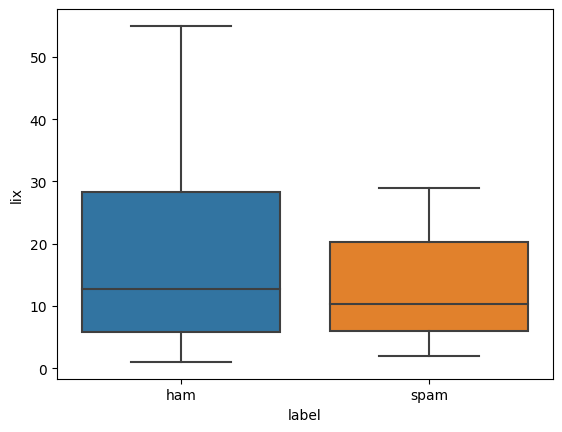

In [7]:
import seaborn as sns
sns.boxplot(x="label", y="lix", data=df)

Let's run a quick test to see if any of our metrics correlate strongly with the label

In [8]:
# encode the label as a boolean
df["is_ham"] = df["label"] == "ham"
# compute the correlation between all metrics and the label
metrics_correlations = metrics.corrwith(df["is_ham"]).sort_values(key=abs, ascending=False)
metrics_correlations[:10]

smog                                      0.211242
syllables_per_token_median                0.202707
prop_adjacent_dependency_relation_std    -0.183331
token_length_median                       0.181481
prop_adjacent_dependency_relation_mean    0.162512
rix                                       0.157532
proportion_unique_tokens                  0.150327
lix                                       0.129722
sentence_length_median                    0.126950
sentence_length_mean                      0.124367
dtype: float64

That's some pretty high correlations! Notably we see that the mean dependency distance is correlated with `ham`. This makes sense, as the dependency distance is a measure of sentence complexity, and spam messages tend to be shorter and simpler.

Let's try to plot it:

<Axes: xlabel='dependency_distance_mean', ylabel='Density'>

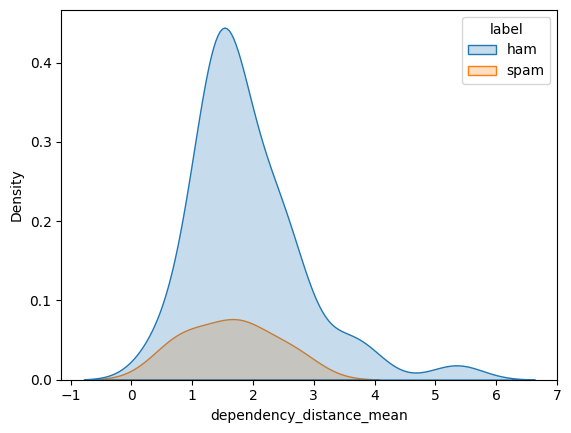

In [9]:
sns.kdeplot(df, x="dependency_distance_mean", hue="label", fill=True)

We can do a similar thing for the `lix` score, where we see that here isn't a big difference between the two classes:

<Axes: xlabel='lix', ylabel='Density'>

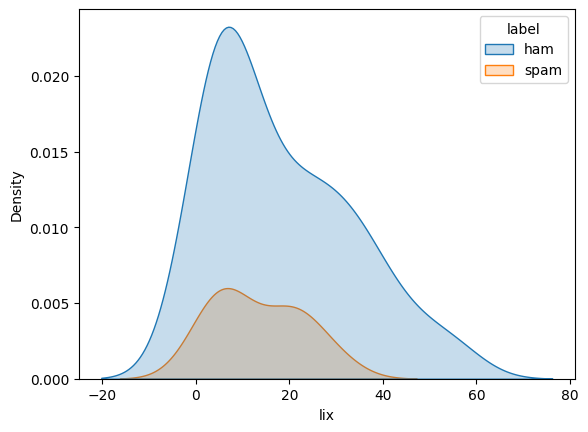

In [10]:
sns.kdeplot(df, x="lix", hue="label", fill=True)

Cool! We've now done a quick analysis of the SMS dataset and found some differences in the distributions of some readability and dependency-distance metrics between the actual SMS's and spam. 

Next steps could be continue the exploratory data analysis or to build a simple classifier using the extracted metrics.